<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

# Explore our Data & Preprocess

In [2]:
import os
# Create a path to the root folder and path to specific folders on my computer
data_path = "data/CellData/chest_xray/"

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train/')
test_folder = os.path.join(data_path, 'test/')
val_folder = os.path.join(data_path, 'validation/')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

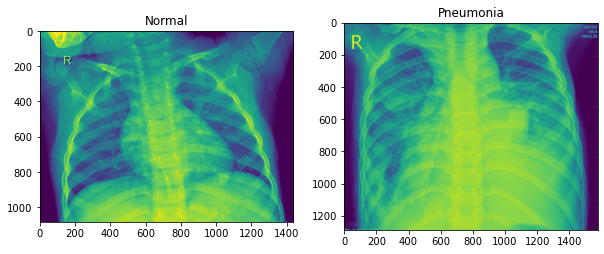

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Read images
# img1 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
# img1 = Image.open("data/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("data/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")

# img1 = Image.open(r"data\CellData\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg")
# img2 = Image.open(r"data\CellData\chest_xray\train\PNEUMONIA\BACTERIA-37006-0002.jpeg")


img1 = Image.open(r"data\CellData\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg")
img2 = Image.open(r"data\CellData\chest_xray\train\PNEUMONIA\BACTERIA-37006-0002.jpeg")

# Display images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Normal')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Pneumonia')

plt.show()

It seems that the images are not actually on the same size. Visually we can see the bacterial infection. We would have to preprocess the images to become the same size and also lower the scale since training a neuwral network is resource intensive. Lets explore how many images we have in each directory.

In [4]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1080 normal images in the training set
There are 3108 pneumonia images in the training set
________________________________________________________________________________________
There are 235 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 269 normal images in the validation set
There are 776 pneumonia images in the validation set


Lets preprocess the images by resizing to (256, 256, 3)

In [5]:
from functions import process_data

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(256, 64, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


It seems the generators are working as expected. The main downside is that the image genertaor does not let us know what images are normal and pneumonia but its labeled for us as 1, 0. Lets take a batch of images and see what we see so we know what is Normal and Peneumonia.

Image dimensions: (256, 256, 3)


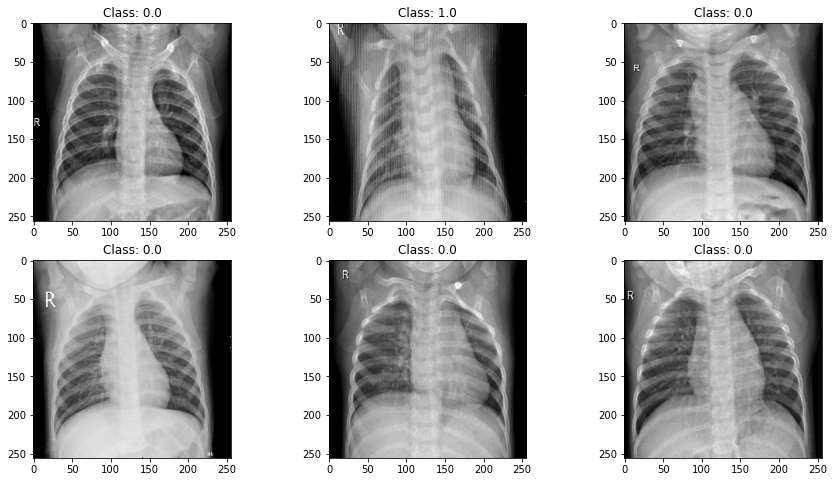

In [6]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {labels[0]}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {labels[1]}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {labels[2]}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {labels[3]}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {labels[4]}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {labels[5]}")

plt.show()

It seems images that arer very cloudy in the chest are Pneumonia while normal images are very clear. This means 1 is Pneumonia and 0 is Normal.

Image dimensions: (256, 256, 3)


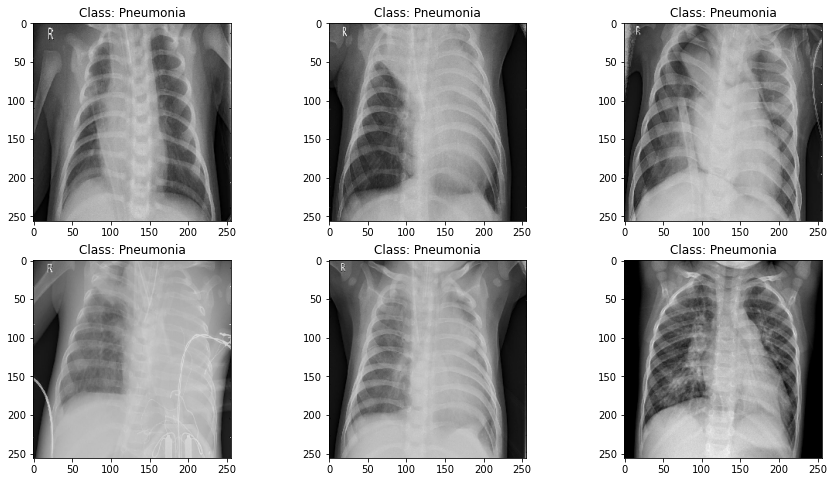

In [7]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {'Normal' if labels[1] == 0 else 'Pneumonia'}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {'Normal' if labels[2] == 0 else 'Pneumonia'}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {'Normal' if labels[3] == 0 else 'Pneumonia'}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {'Normal' if labels[4] == 0 else 'Pneumonia'}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {'Normal' if labels[5] == 0 else 'Pneumonia'}")

plt.show()


We sucecssfully resized the images and also created an RGB tensor. Lets create our datasets

# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [8]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.losses import BinaryCrossentropy


# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
# Flatten layer to reshape the output
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(128, activation='relu'))

# Define the output 
model_mlp_base.add(Dense(1, activation='sigmoid'))


model_mlp_base.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25165952  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 25,166,081
Trainable params: 25,166,081
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 44s 669ms/step - loss: 0.4610 - precision: 0.7789 - recall: 0.9945 - accuracy: 0.7865 - val_loss: 0.3577 - val_precision: 0.8054 - val_recall: 0.9974 - val_accuracy: 0.8191
Epoch 2/15
66/66 [==============================] - 38s 582ms/step - loss: 0.3289 - precision: 0.8663 - recall: 0.9800 - accuracy: 0.8729 - val_loss: 0.2785 - val_precision: 0.9361 - val_recall: 0.9626 - val_accuracy: 0.9234
Epoch 3/15
66/66 [==============================] - 38s 580ms/step - loss: 0.2760 - precision: 0.9046 - recall: 0.9707 - accuracy: 0.9023 - val_loss: 0.2465 - val_precision: 0.9059 - val_recall: 0.9923 - val_accuracy: 0.9177
Epoch 4/15
66/66 [==============================] - 39s 584ms/step - loss: 0.2457 - precision: 0.9154 - recall: 0.9681 - accuracy: 0.9100 - val_loss: 0.2145 - val_precision: 0.9485 - val_recall: 0.9729 - val_accuracy: 0.9407
Epoch 5/15
66/66 [==============================] - 38s 582ms/step - loss: 0.2210 - precision: 0.927

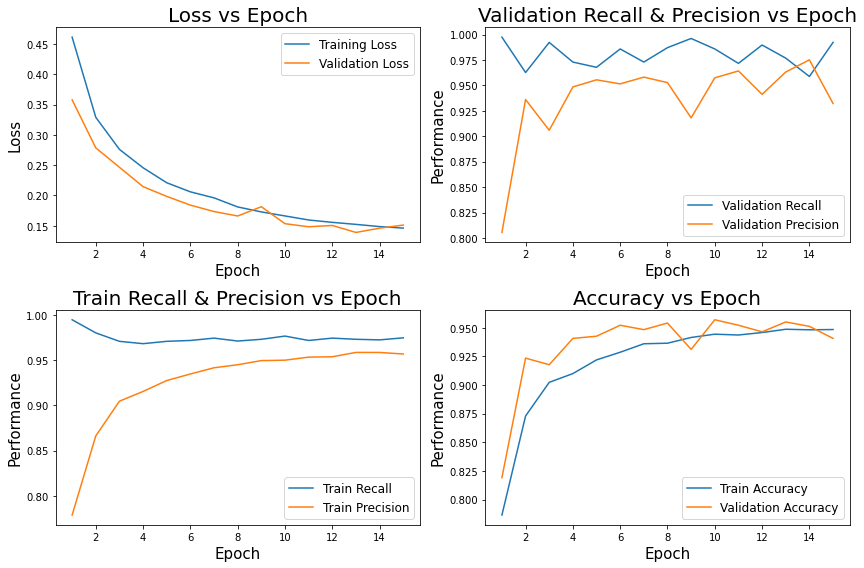

17/17 [==============================] - 7s 389ms/step - loss: 0.1512 - precision: 0.9322 - recall: 0.9923 - accuracy: 0.9407


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.150777,93.887532,98.873514,94.387388
1,Test,0.501634,75.195312,98.717946,78.846157
2,Validation,0.151153,93.220341,99.226803,94.066983


In [10]:
from functions import train_model, view_history, model_evaluate

mlp = {}

# Train the model
mlp['Version1'] = train_model(model_mlp_base, train_gen, val_gen, total_epochs=15)

# View History 
view_history(mlp, 'Version1')

# Evaluate model
model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

This looks good. We generally follow closely with both curves. We can see how we diverged then reconverged. Perhaps we should try less neurons for the first layer

# MLP Version 2

In [11]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(192, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 192)               37748928  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 193       
Total params: 37,749,121
Trainable params: 37,749,121
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 41s 624ms/step - loss: 0.4471 - precision: 0.8140 - recall: 0.9928 - accuracy: 0.7977 - val_loss: 0.3298 - val_precision: 0.8779 - val_recall: 0.9820 - val_accuracy: 0.8852
Epoch 2/15
66/66 [==============================] - 40s 609ms/step - loss: 0.3038 - precision: 0.8874 - recall: 0.9765 - accuracy: 0.8906 - val_loss: 0.2628 - val_precision: 0.9459 - val_recall: 0.9472 - val_accuracy: 0.9206
Epoch 3/15
66/66 [==============================] - 40s 604ms/step - loss: 0.2504 - precision: 0.9148 - recall: 0.9717 - accuracy: 0.9119 - val_loss: 0.2205 - val_precision: 0.9185 - val_recall: 0.9871 - val_accuracy: 0.9254
Epoch 4/15
66/66 [==============================] - 40s 601ms/step - loss: 0.2210 - precision: 0.9284 - recall: 0.9723 - accuracy: 0.9238 - val_loss: 0.2013 - val_precision: 0.9599 - val_recall: 0.9562 - val_accuracy: 0.9378
Epoch 5/15
66/66 [==============================] - 40s 603ms/step - loss: 0.2011 - precision: 0.933

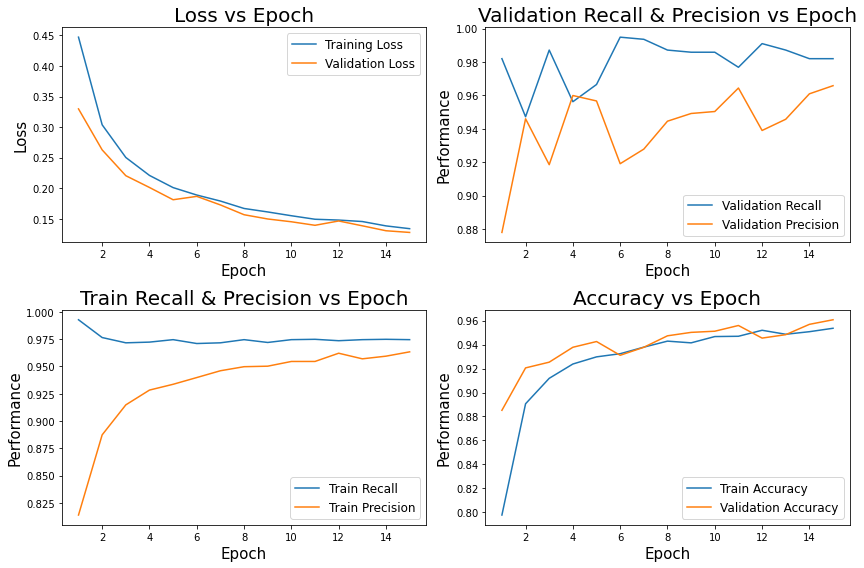

17/17 [==============================] - 7s 412ms/step - loss: 0.1277 - precision: 0.9658 - recall: 0.9820 - accuracy: 0.9608


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.130660,96.675193,97.328615,95.533794
1,Test,0.399070,79.545456,98.717946,83.333331
2,Validation,0.127731,96.577948,98.195875,96.076554


In [12]:
from functions import train_model, view_history, model_evaluate
mlp = {}
# Update our dictionary with Version 2
mlp['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=15)

# View History
view_history(mlp, 'Version2')

# Evaluate model
model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

It seems that more neurons made generalize better. That means we can increase the neurons more since we are still generally still decreasing together.

# MLP Version 3

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(256, activation='relu'))

# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               50331904  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 50,332,161
Trainable params: 50,332,161
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 43s 650ms/step - loss: 0.4728 - precision: 0.8086 - recall: 0.9760 - accuracy: 0.7733 - val_loss: 0.3468 - val_precision: 0.8984 - val_recall: 0.9691 - val_accuracy: 0.8957
Epoch 2/15
66/66 [==============================] - 42s 641ms/step - loss: 0.3189 - precision: 0.8800 - recall: 0.9701 - accuracy: 0.8796 - val_loss: 0.2670 - val_precision: 0.8993 - val_recall: 0.9897 - val_accuracy: 0.9100
Epoch 3/15
66/66 [==============================] - 42s 641ms/step - loss: 0.2576 - precision: 0.9130 - recall: 0.9723 - accuracy: 0.9107 - val_loss: 0.2245 - val_precision: 0.9250 - val_recall: 0.9858 - val_accuracy: 0.9301
Epoch 4/15
66/66 [==============================] - 42s 643ms/step - loss: 0.2281 - precision: 0.9266 - recall: 0.9714 - accuracy: 0.9217 - val_loss: 0.2027 - val_precision: 0.9276 - val_recall: 0.9910 - val_accuracy: 0.9359
Epoch 5/15
66/66 [==============================] - 42s 640ms/step - loss: 0.2035 - precision: 0.937

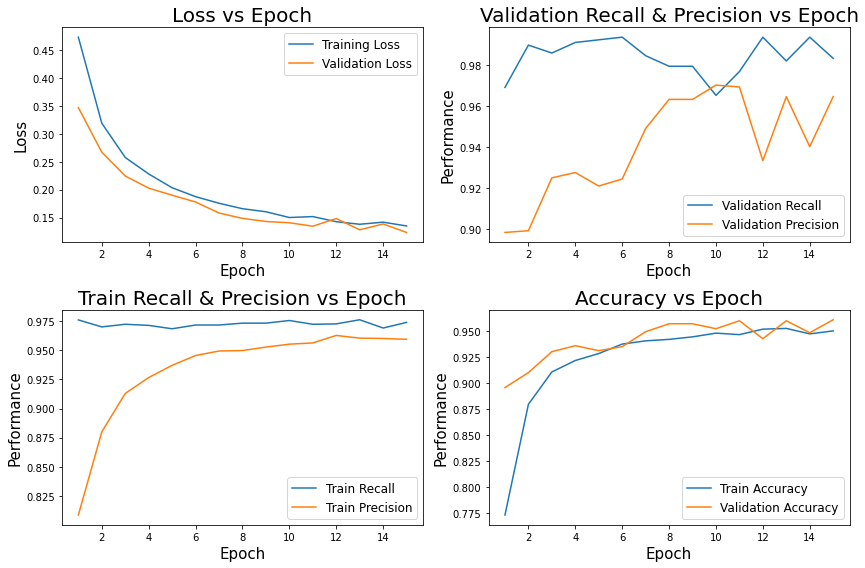

17/17 [==============================] - 7s 404ms/step - loss: 0.1235 - precision: 0.9646 - recall: 0.9832 - accuracy: 0.9608


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.126186,96.352679,97.779208,95.605445
1,Test,0.413913,79.055440,98.717946,82.852566
2,Validation,0.123548,96.460176,98.324740,96.076554


In [14]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 3
mlp['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version3')

# Evaluate model
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

It seems we did better but not by much so perhaps we should add another layer to see if our metrics improve as well as loss. 

# MLP Version 4

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_4 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_4.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_4.add(Dense(256, activation='relu'))
model_mlp_base_4.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_4.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               50331904  
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 50,348,417
Trainable params: 50,348,417
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 43s 655ms/step - loss: 0.4206 - precision: 0.8369 - recall: 0.9779 - accuracy: 0.8125 - val_loss: 0.2923 - val_precision: 0.8968 - val_recall: 0.9858 - val_accuracy: 0.9053
Epoch 2/15
66/66 [==============================] - 43s 647ms/step - loss: 0.2721 - precision: 0.9002 - recall: 0.9697 - accuracy: 0.8978 - val_loss: 0.2207 - val_precision: 0.9413 - val_recall: 0.9704 - val_accuracy: 0.9330
Epoch 3/15
66/66 [==============================] - 42s 642ms/step - loss: 0.2306 - precision: 0.9242 - recall: 0.9620 - accuracy: 0.9133 - val_loss: 0.1924 - val_precision: 0.9377 - val_recall: 0.9884 - val_accuracy: 0.9426
Epoch 4/15
66/66 [==============================] - 42s 639ms/step - loss: 0.2044 - precision: 0.9368 - recall: 0.9681 - accuracy: 0.9279 - val_loss: 0.1780 - val_precision: 0.9662 - val_recall: 0.9575 - val_accuracy: 0.9435
Epoch 5/15
66/66 [==============================] - 42s 636ms/step - loss: 0.1832 - precision: 0.946

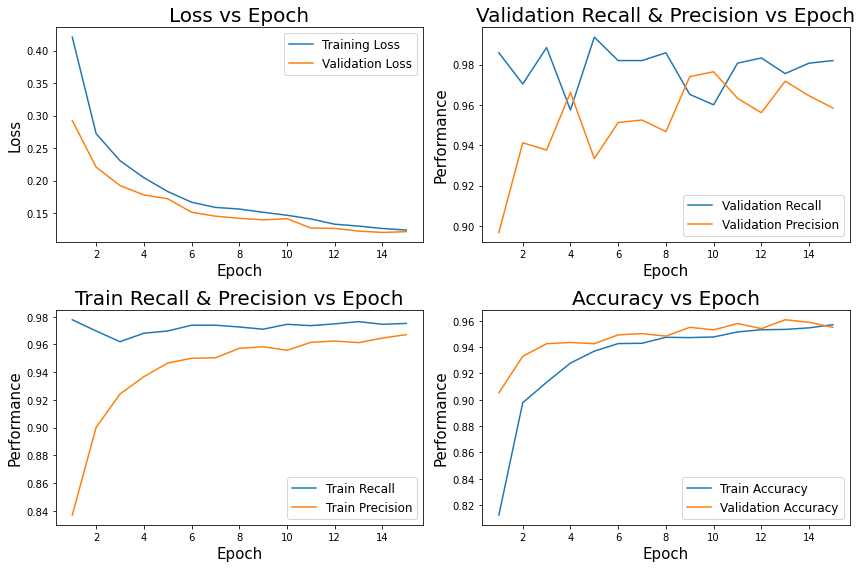

17/17 [==============================] - 7s 411ms/step - loss: 0.1214 - precision: 0.9585 - recall: 0.9820 - accuracy: 0.9550


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.119902,96.363062,98.068875,95.820397
1,Test,0.454658,77.464789,98.717946,81.250000
2,Validation,0.121419,95.849055,98.195875,95.502394


In [16]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 4
mlp['Version4'] = train_model(model_mlp_base_4, train_gen, val_gen, total_epochs=15)

# View history 
view_history(mlp, 'Version4')

# Evaluate model
model_evaluate(model_mlp_base_4, train_gen, test_gen, val_gen)

It seems we can still generalize more by adding more neurons since the loss curves are still generally close together and decreasing with time. Lets add more neurons again

# MLP Version 5

In [17]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_5 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_5.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_5.add(Dense(256, activation='relu'))
model_mlp_base_5.add(Dense(128, activation='relu'))

# Define output layer
model_mlp_base_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_5.compile(optimizer=Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               50331904  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 50,364,929
Trainable params: 50,364,929
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 43s 653ms/step - loss: 0.4820 - precision: 0.8024 - recall: 0.9755 - accuracy: 0.7657 - val_loss: 0.3595 - val_precision: 0.9104 - val_recall: 0.9562 - val_accuracy: 0.8976
Epoch 2/15
66/66 [==============================] - 42s 639ms/step - loss: 0.3201 - precision: 0.8725 - recall: 0.9755 - accuracy: 0.8760 - val_loss: 0.2667 - val_precision: 0.8992 - val_recall: 0.9884 - val_accuracy: 0.9091
Epoch 3/15
66/66 [==============================] - 42s 641ms/step - loss: 0.2615 - precision: 0.9093 - recall: 0.9707 - accuracy: 0.9064 - val_loss: 0.2276 - val_precision: 0.9206 - val_recall: 0.9858 - val_accuracy: 0.9263
Epoch 4/15
66/66 [==============================] - 42s 637ms/step - loss: 0.2299 - precision: 0.9244 - recall: 0.9717 - accuracy: 0.9200 - val_loss: 0.2020 - val_precision: 0.9329 - val_recall: 0.9858 - val_accuracy: 0.9368
Epoch 5/15
66/66 [==============================] - 42s 633ms/step - loss: 0.2053 - precision: 0.936

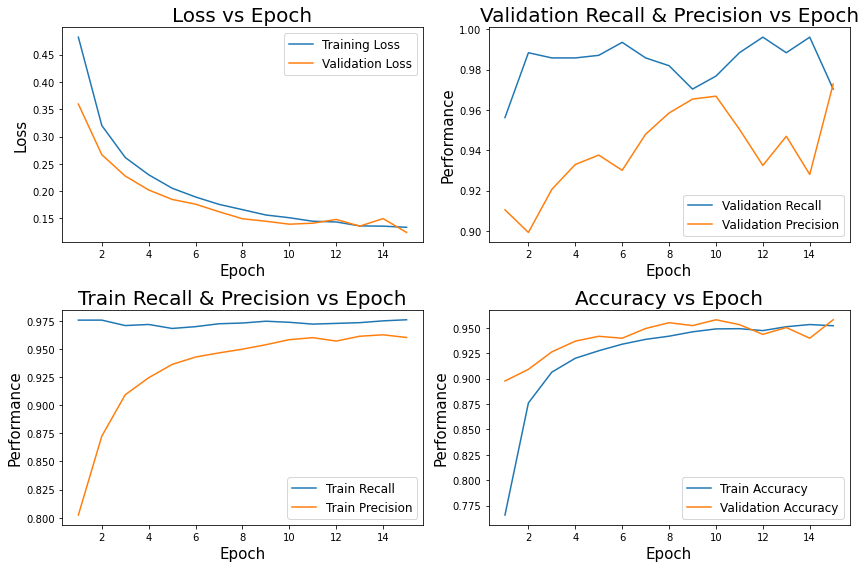

17/17 [==============================] - 7s 409ms/step - loss: 0.1243 - precision: 0.9729 - recall: 0.9704 - accuracy: 0.9579


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.129745,97.564143,96.684903,95.748746
1,Test,0.360059,82.543105,98.205125,85.897434
2,Validation,0.124282,97.286820,97.036082,95.789474


In [18]:
from functions import model_evaluate, train_model, view_history

# Train model and save history
mlp['Version5'] = train_model(model_mlp_base_5, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version5')

# Evaluate model 
model_evaluate(model_mlp_base_5, train_gen, test_gen, val_gen)

Now it seems that we had a bit of an overfit towards the end. It also seems as if it was going to go back to decreasing again with the train curve. Lets attempt more neurons on this second layer just to see what happens. This is also the first version where our test precision passes 80!

# MLP Version 6

In [19]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_6 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_6.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_6.add(Dense(256, activation='relu'))
model_mlp_base_6.add(Dense(192, activation='relu'))


# Define output layer
model_mlp_base_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_6.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               50331904  
_________________________________________________________________
dense_13 (Dense)             (None, 192)               49344     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 193       
Total params: 50,381,441
Trainable params: 50,381,441
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 44s 662ms/step - loss: 0.4422 - precision: 0.8174 - recall: 0.9900 - accuracy: 0.7960 - val_loss: 0.3322 - val_precision: 0.8484 - val_recall: 0.9948 - val_accuracy: 0.8641
Epoch 2/15
66/66 [==============================] - 42s 638ms/step - loss: 0.3076 - precision: 0.8830 - recall: 0.9788 - accuracy: 0.8880 - val_loss: 0.2576 - val_precision: 0.9400 - val_recall: 0.9691 - val_accuracy: 0.9311
Epoch 3/15
66/66 [==============================] - 44s 663ms/step - loss: 0.2532 - precision: 0.9144 - recall: 0.9733 - accuracy: 0.9126 - val_loss: 0.2171 - val_precision: 0.9338 - val_recall: 0.9820 - val_accuracy: 0.9349
Epoch 4/15
66/66 [==============================] - 43s 645ms/step - loss: 0.2227 - precision: 0.9281 - recall: 0.9723 - accuracy: 0.9236 - val_loss: 0.1939 - val_precision: 0.9567 - val_recall: 0.9691 - val_accuracy: 0.9445
Epoch 5/15
66/66 [==============================] - 44s 668ms/step - loss: 0.1992 - precision: 0.937

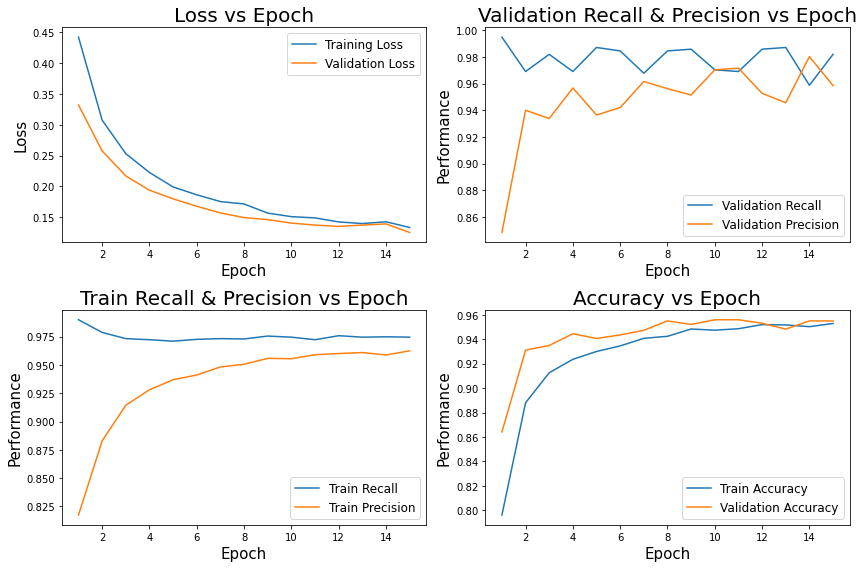

17/17 [==============================] - 7s 397ms/step - loss: 0.1254 - precision: 0.9585 - recall: 0.9820 - accuracy: 0.9550


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.128000,96.261090,97.779208,95.533794
1,Test,0.421637,78.571427,98.717946,82.371795
2,Validation,0.125430,95.849055,98.195875,95.502394


In [20]:
from functions import model_evaluate, view_history, train_model

# Train model
mlp['Version6'] = train_model(model_mlp_base_6, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version6')

# Evaluate model
model_evaluate(model_mlp_base_6, train_gen, test_gen, val_gen)

It seems we still do not overfit. No matter how many neurons we add we arent getting better metrics and we get very little loss improvement

# MLP version 7

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_7 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_7.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_7.add(Dense(256, activation='relu'))
model_mlp_base_7.add(Dense(256, activation='relu'))

# Define output layer
model_mlp_base_7.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_7.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               50331904  
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 50,397,953
Trainable params: 50,397,953
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 43s 658ms/step - loss: 0.4310 - precision: 0.8181 - recall: 0.9918 - accuracy: 0.7991 - val_loss: 0.3201 - val_precision: 0.8771 - val_recall: 0.9936 - val_accuracy: 0.8919
Epoch 2/15
66/66 [==============================] - 45s 678ms/step - loss: 0.2942 - precision: 0.8909 - recall: 0.9775 - accuracy: 0.8944 - val_loss: 0.2513 - val_precision: 0.9006 - val_recall: 0.9923 - val_accuracy: 0.9129
Epoch 3/15
66/66 [==============================] - 43s 655ms/step - loss: 0.2521 - precision: 0.9096 - recall: 0.9656 - accuracy: 0.9033 - val_loss: 0.2132 - val_precision: 0.9253 - val_recall: 0.9897 - val_accuracy: 0.9330
Epoch 4/15
66/66 [==============================] - 42s 639ms/step - loss: 0.2168 - precision: 0.9333 - recall: 0.9678 - accuracy: 0.9248 - val_loss: 0.1955 - val_precision: 0.9254 - val_recall: 0.9910 - val_accuracy: 0.9340
Epoch 5/15
66/66 [==============================] - 43s 657ms/step - loss: 0.1960 - precision: 0.938

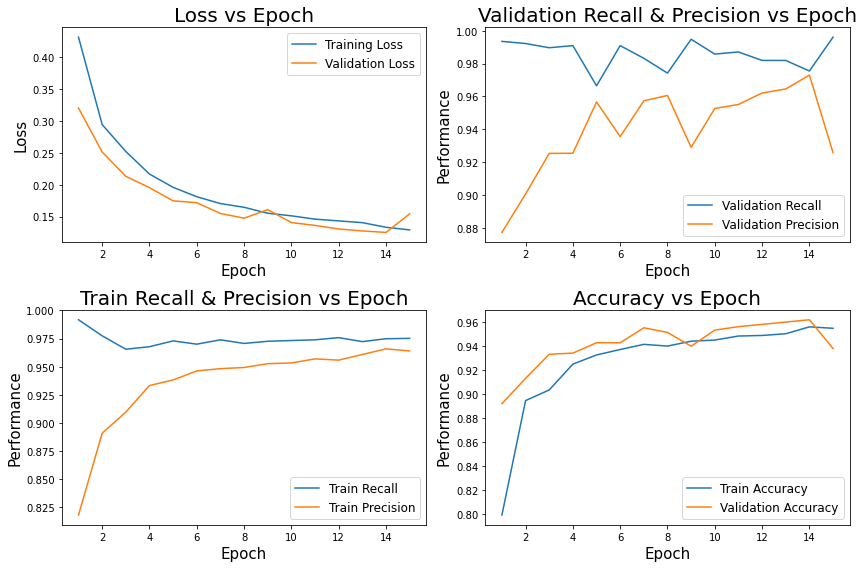

17/17 [==============================] - 7s 407ms/step - loss: 0.1544 - precision: 0.9257 - recall: 0.9961 - accuracy: 0.9378


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.149712,93.270689,99.034441,93.981373
1,Test,0.573822,73.244780,98.974359,76.762819
2,Validation,0.154445,92.574853,99.613404,93.779904


In [22]:
from functions import model_evaluate, train_model, view_history

# Train model
mlp['Version7'] = train_model(model_mlp_base_7, train_gen, val_gen, total_epochs=15)

# View History
view_history(mlp, 'Version7')

# Evaluate model
model_evaluate(model_mlp_base_7, train_gen, test_gen, val_gen)

Now it seems that we did overfit. Lets return to the previous version 6

# MLP Version 8

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_8 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_8.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_8.add(Dense(256, activation='relu'))
model_mlp_base_8.add(Dense(192, activation='relu'))
model_mlp_base_8.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_8.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_8.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               50331904  
_________________________________________________________________
dense_19 (Dense)             (None, 192)               49344     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 50,393,665
Trainable params: 50,393,665
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 45s 681ms/step - loss: 0.4818 - precision: 0.7870 - recall: 0.9985 - accuracy: 0.7636 - val_loss: 0.3747 - val_precision: 0.8644 - val_recall: 0.9858 - val_accuracy: 0.8746
Epoch 2/15
66/66 [==============================] - 44s 665ms/step - loss: 0.3358 - precision: 0.8666 - recall: 0.9781 - accuracy: 0.8720 - val_loss: 0.2865 - val_precision: 0.8712 - val_recall: 0.9936 - val_accuracy: 0.8861
Epoch 3/15
66/66 [==============================] - 43s 645ms/step - loss: 0.2725 - precision: 0.8992 - recall: 0.9765 - accuracy: 0.9014 - val_loss: 0.2361 - val_precision: 0.9380 - val_recall: 0.9742 - val_accuracy: 0.9330
Epoch 4/15
66/66 [==============================] - 42s 642ms/step - loss: 0.2377 - precision: 0.9198 - recall: 0.9714 - accuracy: 0.9159 - val_loss: 0.2081 - val_precision: 0.9429 - val_recall: 0.9781 - val_accuracy: 0.9397
Epoch 5/15
66/66 [==============================] - 42s 637ms/step - loss: 0.2152 - precision: 0.933

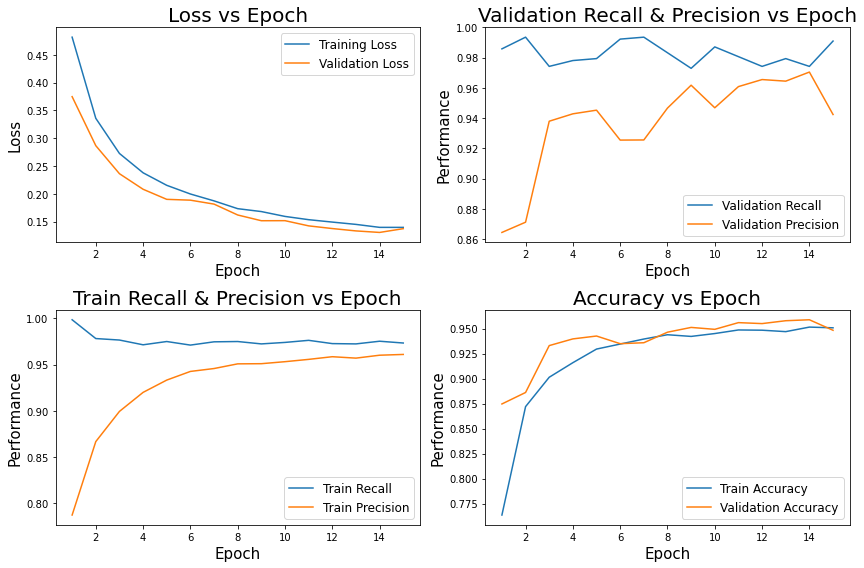

17/17 [==============================] - 7s 399ms/step - loss: 0.1371 - precision: 0.9424 - recall: 0.9910 - accuracy: 0.9483


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.137161,94.886893,98.551655,94.984478
1,Test,0.469800,75.787401,98.717946,79.487181
2,Validation,0.137147,94.240195,99.097937,94.832534


In [24]:
from functions import model_evaluate, train_model, view_history

#Train model
mlp['Version8'] = train_model(model_mlp_base_8, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, "Version8")

# Evaluate model
model_evaluate(model_mlp_base_8, train_gen, test_gen, val_gen)

Its seems that Dense layers has reached its potential in feature extraction. Our loss metrics do not seem to be improving much. Our best performace was Version 6. Lets save tha model 

In [25]:
# Save Version 6 
model_directory = 'models/'

model_mlp_base_6.save(model_directory + 'mlpv6.keras')
model_mlp_base_8.save(model_directory + 'mlpv8.keras')

# Convolutional Neural Network


Based off our work from the MLP section Version 6 was our best model performance for loss and not overfitting. Now lets attempt to make a Convolutional Network. 

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_1 = Sequential()

# Define our Conv layer to capture more global features by making Kernel size bigger
cnn_1.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=input_shape))
cnn_1.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# Define the Dense Layers
cnn_1.add(Flatten())
cnn_1.add(Dense(256, activation='relu'))

# Define output layer
cnn_1.add(Dense(1, activation='sigmoid'))


# Compile the model
cnn_1.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               134217984 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 134,220,673
Trainable params: 134,220,673
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 98s 1s/step - loss: 0.5299 - precision: 0.7433 - recall: 0.9842 - accuracy: 0.7361 - val_loss: 0.4477 - val_precision: 0.7440 - val_recall: 1.0000 - val_accuracy: 0.7445
Epoch 2/15
66/66 [==============================] - 96s 1s/step - loss: 0.4070 - precision: 0.7941 - recall: 0.9945 - accuracy: 0.8046 - val_loss: 0.3498 - val_precision: 0.8631 - val_recall: 0.9910 - val_accuracy: 0.8766
Epoch 3/15
66/66 [==============================] - 95s 1s/step - loss: 0.3352 - precision: 0.8664 - recall: 0.9829 - accuracy: 0.8749 - val_loss: 0.2981 - val_precision: 0.8616 - val_recall: 0.9948 - val_accuracy: 0.8775
Epoch 4/15
66/66 [==============================] - 95s 1s/step - loss: 0.2865 - precision: 0.8975 - recall: 0.9781 - accuracy: 0.9009 - val_loss: 0.2528 - val_precision: 0.9282 - val_recall: 0.9832 - val_accuracy: 0.9311
Epoch 5/15
66/66 [==============================] - 97s 1s/step - loss: 0.2529 - precision: 0.9169 - recall: 0.9

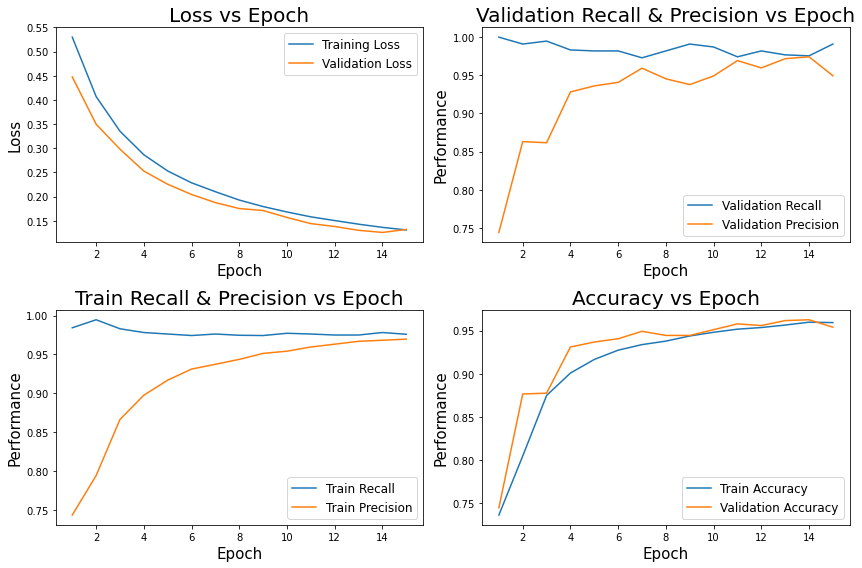

17/17 [==============================] - 9s 531ms/step - loss: 0.1320 - precision: 0.9494 - recall: 0.9910 - accuracy: 0.9541


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.133131,95.020103,98.873514,95.318842
1,Test,0.402754,77.490038,99.743587,81.730771
2,Validation,0.131990,94.938272,99.097937,95.406699


In [10]:
from functions import train_model, model_evaluate, view_history

cnn = {}

# Train model
cnn['Version1'] = train_model(cnn_1, train_gen, val_gen, 15)

# View history 
view_history(cnn, 'Version1')

# Evalaute model
model_evaluate(cnn_1, train_gen, test_gen, val_gen)

It seems that using a single ConV layer with one hidden Dense layer did just as great as our best MLP model. The metrics are also nearly the same. According to our loss curves we seem to be overfitting as the curves are beginning to converge into eachother. That being said lets add some regularization to generalize better.

# CNN Version 2

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_2 = Sequential()

# Define the layers
# Define our Conv layer
cnn_2.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=input_shape))
cnn_2.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# Flatten the input layer for the Dense layers
cnn_2.add(Flatten())

# Define our Dense Layers
cnn_2.add(Dense(256, activation='relu'))
cnn_2.add(Dropout(rate=0.20, seed=42))


# Define output layer
cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_2.compile(optimizer=Adam(0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               134217984 
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 134,253,441
Trainable params: 134,253,441
Non-trainable params: 0
________________________________________

Epoch 1/15
66/66 [==============================] - 97s 1s/step - loss: 0.5203 - precision: 0.7770 - recall: 0.9869 - accuracy: 0.7366 - val_loss: 0.4394 - val_precision: 0.7490 - val_recall: 1.0000 - val_accuracy: 0.7512
Epoch 2/15
66/66 [==============================] - 95s 1s/step - loss: 0.3913 - precision: 0.8110 - recall: 0.9942 - accuracy: 0.8237 - val_loss: 0.3368 - val_precision: 0.9073 - val_recall: 0.9832 - val_accuracy: 0.9129
Epoch 3/15
66/66 [==============================] - 95s 1s/step - loss: 0.3154 - precision: 0.8835 - recall: 0.9839 - accuracy: 0.8918 - val_loss: 0.2766 - val_precision: 0.9046 - val_recall: 0.9897 - val_accuracy: 0.9148
Epoch 4/15
66/66 [==============================] - 97s 1s/step - loss: 0.2724 - precision: 0.9058 - recall: 0.9807 - accuracy: 0.9100 - val_loss: 0.2425 - val_precision: 0.9436 - val_recall: 0.9704 - val_accuracy: 0.9349
Epoch 5/15
66/66 [==============================] - 96s 1s/step - loss: 0.2409 - precision: 0.9269 - recall: 0.9

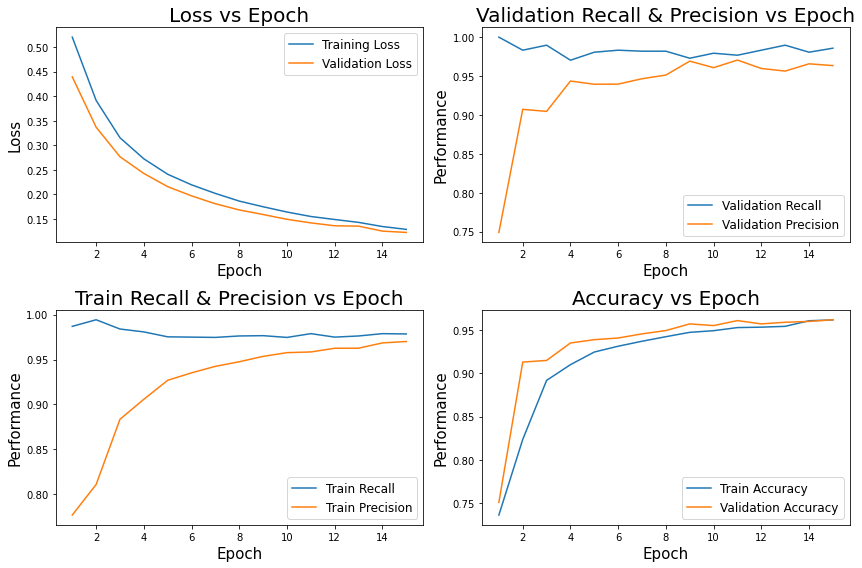

17/17 [==============================] - 9s 525ms/step - loss: 0.1224 - precision: 0.9635 - recall: 0.9858 - accuracy: 0.9617


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.125639,96.583360,98.261988,96.130884
1,Test,0.346946,79.550099,99.743587,83.814102
2,Validation,0.122427,96.347606,98.582476,96.172249


In [12]:
from functions import train_model, model_evaluate, view_history

# Train the model
cnn['Version2'] = train_model(cnn_2, train_gen, val_gen, 15)

# View History 
view_history(cnn, "Version2")

# Evalauate Model
model_evaluate(cnn_2, train_gen, test_gen, val_gen)

The loss are curves still did not diverge with a larger dense netowork. Now that we should consider finer details in the conv layers

# CNN Version 3

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_3 = Sequential()

# Define the layers
# Define our Conv layer
cnn_3.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=input_shape))
cnn_3.add(MaxPool2D(pool_size=(2, 2), padding='same'))
cnn_3.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
cnn_3.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# Flatten the input layer for the Dense layers
cnn_3.add(Flatten())

# Define our Dense Layers
cnn_3.add(Dense(256, activation='relu'))
cnn_3.add(Dense(128, activation='relu'))

# Define output layer
cnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_3.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

Epoch 1/15
66/66 [==============================] - 100s 2s/step - loss: 0.5973 - precision: 0.7788 - recall: 0.9781 - accuracy: 0.7316 - val_loss: 0.5567 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/15
66/66 [==============================] - 97s 1s/step - loss: 0.5452 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.5284 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 3/15
66/66 [==============================] - 98s 1s/step - loss: 0.5168 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.4972 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 4/15
66/66 [==============================] - 98s 1s/step - loss: 0.4872 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.4667 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 5/15
66/66 [==============================] - 99s 1s/step - loss: 0.4578 - precision: 0.7442 - recall: 1.

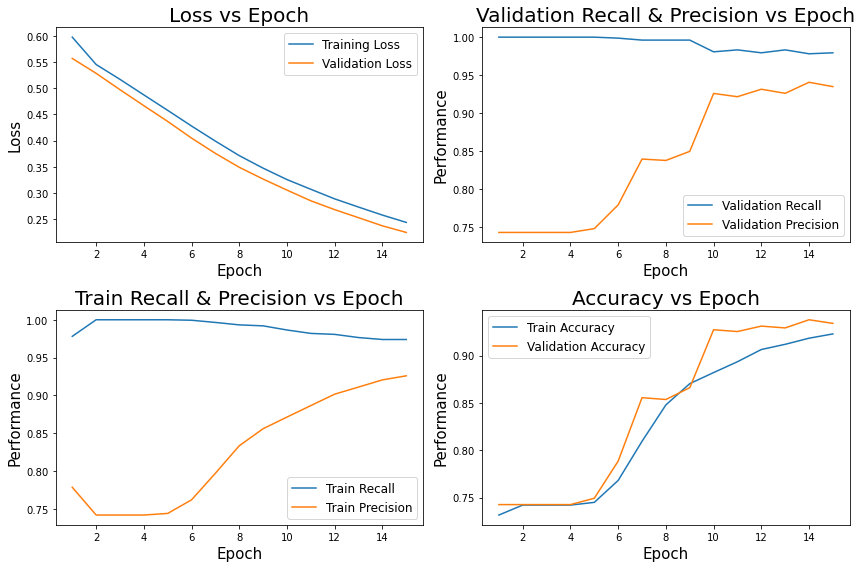

17/17 [==============================] - 9s 513ms/step - loss: 0.2251 - precision: 0.9348 - recall: 0.9794 - accuracy: 0.9340


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.237476,92.883438,97.457355,92.572248
1,Test,0.380407,76.999998,98.717946,80.769229
2,Validation,0.225148,93.480933,97.938144,93.397129


In [14]:
from functions import train_model, view_history, model_evaluate
cnn={}
# Train model
cnn['Version3'] = train_model(cnn_3, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version3')

# Evaluate Model
model_evaluate(cnn_3, train_gen, test_gen, val_gen)

It seems we are going to need more training time as our curve could have kept going. Besides this we can also see that the curve never diverged again. Since we have more information with our new ConV layer we should try adding more neurons and we can remove a max pool layer to introduce more spatial info for the dense layers

# CNN Version 4


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_4 = Sequential()

# Define the layers
# Define our Conv layer
cnn_4.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=input_shape))
cnn_4.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
cnn_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# Flatten the input layer for the Dense layers
cnn_4.add(Flatten())

# Define our Dense Layers
cnn_4.add(Dense(256, activation='relu'))
cnn_4.add(Dense(196, activation='relu'))
cnn_4.add(Dense(128, activation='relu'))

# Define output layer
cnn_4.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_4.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               134217984 
_________________________________________________________________
dense_9 (Dense)              (None, 196)               50372     
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

Epoch 1/25
66/66 [==============================] - 203s 3s/step - loss: 0.5604 - precision: 0.7734 - recall: 0.9959 - accuracy: 0.7421 - val_loss: 0.5084 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 196s 3s/step - loss: 0.4742 - precision: 0.7438 - recall: 1.0000 - accuracy: 0.7444 - val_loss: 0.4236 - val_precision: 0.7628 - val_recall: 0.9987 - val_accuracy: 0.7684
Epoch 3/25
66/66 [==============================] - 196s 3s/step - loss: 0.4029 - precision: 0.7976 - recall: 0.9958 - accuracy: 0.8094 - val_loss: 0.3618 - val_precision: 0.8359 - val_recall: 0.9974 - val_accuracy: 0.8526
Epoch 4/25
66/66 [==============================] - 196s 3s/step - loss: 0.3528 - precision: 0.8445 - recall: 0.9910 - accuracy: 0.8579 - val_loss: 0.3171 - val_precision: 0.8790 - val_recall: 0.9923 - val_accuracy: 0.8928
Epoch 5/25
66/66 [==============================] - 201s 3s/step - loss: 0.3116 - precision: 0.8858 - recall

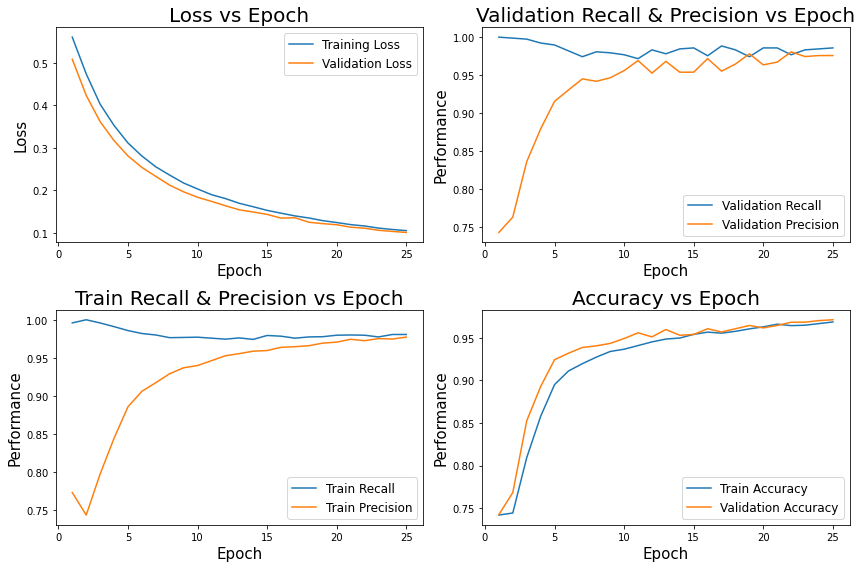

17/17 [==============================] - 10s 603ms/step - loss: 0.1012 - precision: 0.9758 - recall: 0.9858 - accuracy: 0.9713


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.102195,97.661757,98.133248,96.871269
1,Test,0.333150,81.856543,99.487180,85.897434
2,Validation,0.101183,97.576529,98.582476,97.129184


In [16]:
from functions import view_history, model_evaluate, train_model
# Train model

cnn['Version4'] = train_model(cnn_4, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version4')

# Evaluate Model
model_evaluate(cnn_4, train_gen, test_gen, val_gen)

# CNN Version 5 

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_5 = Sequential()

# Define the layers
# Define our Conv layer
cnn_5.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=input_shape))
cnn_5.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same', input_shape=input_shape))
cnn_5.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_5.add(Flatten())

# Define our Dense Layers
cnn_5.add(Dense(256, activation='relu'))
cnn_5.add(Dense(196, activation='relu'))
cnn_5.add(Dense(128, activation='relu'))
cnn_5.add(Dense(128, activation='relu'))

# Define output layer
cnn_5.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_5.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               134217984 
_________________________________________________________________
dense_13 (Dense)             (None, 196)               50372     
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

Epoch 1/25
66/66 [==============================] - 209s 3s/step - loss: 0.5856 - precision: 0.7792 - recall: 0.9969 - accuracy: 0.7423 - val_loss: 0.5432 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 221s 3s/step - loss: 0.5164 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.4769 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 3/25
66/66 [==============================] - 209s 3s/step - loss: 0.4534 - precision: 0.7490 - recall: 0.9997 - accuracy: 0.7511 - val_loss: 0.4123 - val_precision: 0.7719 - val_recall: 0.9987 - val_accuracy: 0.7799
Epoch 4/25
66/66 [==============================] - 202s 3s/step - loss: 0.3976 - precision: 0.8036 - recall: 0.9968 - accuracy: 0.8168 - val_loss: 0.3588 - val_precision: 0.8532 - val_recall: 0.9961 - val_accuracy: 0.8699
Epoch 5/25
66/66 [==============================] - 202s 3s/step - loss: 0.3493 - precision: 0.8533 - recall

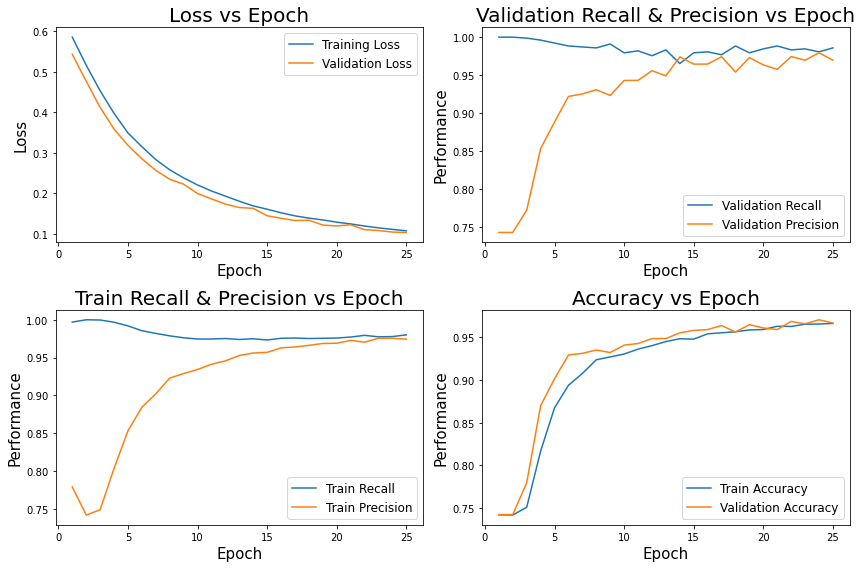

17/17 [==============================] - 10s 599ms/step - loss: 0.1036 - precision: 0.9696 - recall: 0.9858 - accuracy: 0.9665


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.104933,97.321427,98.229802,96.68020
1,Test,0.345527,81.171548,99.487180,85.25641
2,Validation,0.103569,96.958172,98.582476,96.65072


In [18]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version5'] = train_model(cnn_5, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version5')

# Evaluate Model
model_evaluate(cnn_5, train_gen, test_gen, val_gen)

This is good progress as our test loss is now .2 less than what it was. Adding more regularization is helping. Lets keep the same architecture but increase dropout 

# CNN Version 6

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_6 = Sequential()

# Define the layers
# Define our Conv layer
cnn_6.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=input_shape))
cnn_6.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same', input_shape=input_shape))
cnn_6.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_6.add(Flatten())

# Define our Dense Layers
cnn_6.add(Dense(256, activation='relu'))
cnn_6.add(Dense(196, activation='relu'))
cnn_6.add(Dense(128, activation='relu'))
cnn_6.add(Dense(128, activation='relu'))
cnn_5.add(Dense(128, activation='relu'))


# Define output layer
cnn_6.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_6.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               134217984 
_________________________________________________________________
dense_18 (Dense)             (None, 196)               50372     
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

Epoch 1/25
66/66 [==============================] - 191s 3s/step - loss: 0.5639 - precision: 0.7776 - recall: 0.9876 - accuracy: 0.7349 - val_loss: 0.5089 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 190s 3s/step - loss: 0.4741 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.4264 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 3/25
66/66 [==============================] - 190s 3s/step - loss: 0.4038 - precision: 0.7578 - recall: 1.0000 - accuracy: 0.7628 - val_loss: 0.3659 - val_precision: 0.7990 - val_recall: 0.9987 - val_accuracy: 0.8124
Epoch 4/25
66/66 [==============================] - 189s 3s/step - loss: 0.3555 - precision: 0.8236 - recall: 0.9961 - accuracy: 0.8388 - val_loss: 0.3257 - val_precision: 0.8332 - val_recall: 0.9974 - val_accuracy: 0.8498
Epoch 5/25
66/66 [==============================] - 189s 3s/step - loss: 0.3181 - precision: 0.8734 - recall

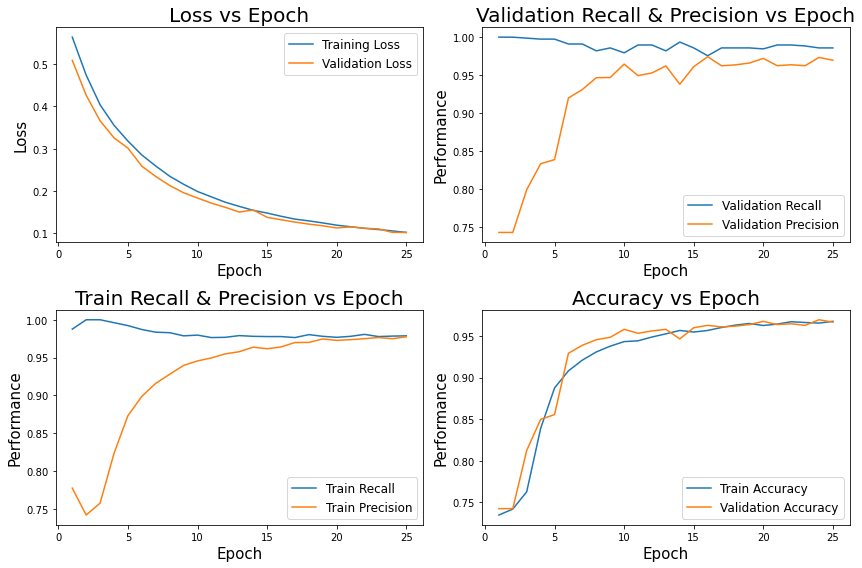

17/17 [==============================] - 10s 601ms/step - loss: 0.1020 - precision: 0.9696 - recall: 0.9858 - accuracy: 0.9665


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.100127,97.171009,98.390728,96.680200
1,Test,0.386405,79.835391,99.487180,83.974361
2,Validation,0.102004,96.958172,98.582476,96.650720


In [20]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version6'] = train_model(cnn_6, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version6')

# Evaluate Model
model_evaluate(cnn_6, train_gen, test_gen, val_gen)

We can see how we start to overfit with every epoch very slowly. To confirm lets just increase the information recieved by the dense layers by increase our filters since it is a little difficult to tell.

# CNN version 7

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_7 = Sequential()

# Define the layers
# Define our Conv layer
cnn_7.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_7.add(MaxPool2D())
cnn_7.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
cnn_7.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_7.add(Flatten())

# Define our Dense Layers
cnn_7.add(Dense(64, activation='relu'))
cnn_7.add(Dropout(0.4, seed=42))
cnn_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_7.add(Dropout(0.4, seed=42))
cnn_7.add(Dense(64, activation='relu'))
cnn_7.add(Dropout(0.4, seed=42))
cnn_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_7.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_7.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_7.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4194368   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

Epoch 1/15
123/123 [==============================] - 81s 657ms/step - loss: 6.8111 - precision: 0.8143 - recall: 0.9421 - accuracy: 0.7372 - val_loss: 2.3561 - val_precision: 0.9796 - val_recall: 0.9897 - val_accuracy: 0.9723
Epoch 2/15
123/123 [==============================] - 79s 639ms/step - loss: 1.2127 - precision: 0.9213 - recall: 0.9599 - accuracy: 0.9156 - val_loss: 0.3922 - val_precision: 0.9939 - val_recall: 0.9734 - val_accuracy: 0.9707
Epoch 3/15
123/123 [==============================] - 78s 634ms/step - loss: 0.3170 - precision: 0.9599 - recall: 0.9595 - accuracy: 0.9443 - val_loss: 0.1385 - val_precision: 0.9964 - val_recall: 0.9631 - val_accuracy: 0.9638
Epoch 4/15
123/123 [==============================] - 78s 637ms/step - loss: 0.1822 - precision: 0.9773 - recall: 0.9673 - accuracy: 0.9619 - val_loss: 0.0786 - val_precision: 0.9948 - val_recall: 0.9897 - val_accuracy: 0.9861
Epoch 5/15
123/123 [==============================] - 78s 636ms/step - loss: 0.1462 - precis

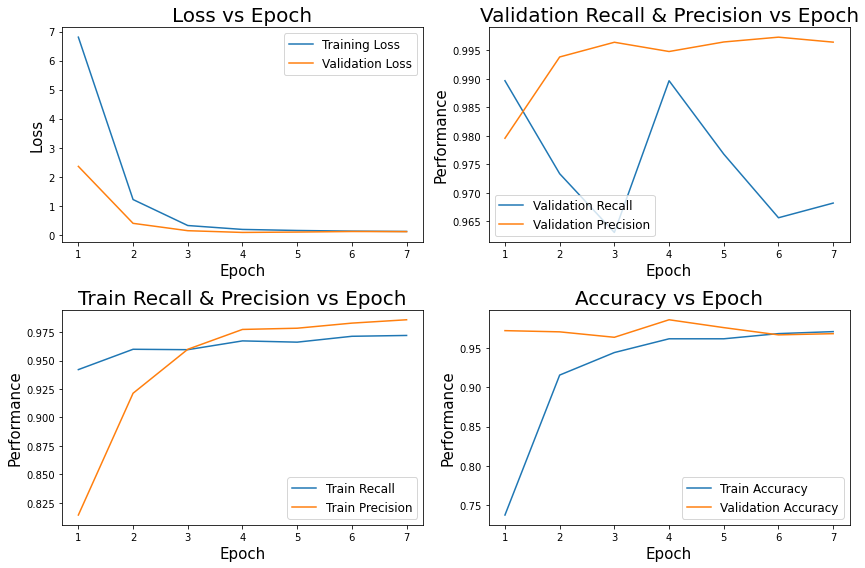

41/41 [==============================] - 13s 324ms/step - loss: 0.0786 - precision: 0.9948 - recall: 0.9897 - accuracy: 0.9861


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.109406,97.566289,98.786318,97.458059
1,Test,0.656452,78.904665,99.743587,83.173078
2,Validation,0.078568,99.481863,98.969072,98.613250


In [20]:
from functions import model_evaluate, train_model, view_history
cnn = {}

# Train model
cnn['Version7'] = train_model(cnn_7, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version7')

# Evaluate Model
model_evaluate(cnn_7, train_gen, test_gen, val_gen)

It seems that version 5 does better. We can attempt to generalize better by maybe adding more dense neurons to the first layer

# CNN Version 8

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_8 = Sequential()

# Define the layers
# Define our Conv layer
cnn_8.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_8.add(MaxPool2D())
cnn_8.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
cnn_8.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_8.add(Flatten())

# Define our Dense Layers
cnn_8.add(Dense(128, activation='relu'))
cnn_8.add(Dropout(.2, seed=42))
cnn_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_8.add(Dense(64, activation='relu'))
cnn_8.add(Dropout(.2, seed=42))
cnn_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_8.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_8.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_8.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

Epoch 1/15
123/123 [==============================] - 82s 668ms/step - loss: 7.1660 - precision: 0.8861 - recall: 0.9518 - accuracy: 0.8363 - val_loss: 2.2743 - val_precision: 0.9981 - val_recall: 0.9270 - val_accuracy: 0.9330
Epoch 2/15
123/123 [==============================] - 79s 645ms/step - loss: 1.0262 - precision: 0.9711 - recall: 0.9640 - accuracy: 0.9553 - val_loss: 0.3363 - val_precision: 0.9965 - val_recall: 0.9863 - val_accuracy: 0.9846
Epoch 3/15
123/123 [==============================] - 79s 644ms/step - loss: 0.2337 - precision: 0.9796 - recall: 0.9735 - accuracy: 0.9677 - val_loss: 0.1184 - val_precision: 0.9906 - val_recall: 0.9931 - val_accuracy: 0.9854
Epoch 4/15
123/123 [==============================] - 81s 657ms/step - loss: 0.1370 - precision: 0.9783 - recall: 0.9772 - accuracy: 0.9692 - val_loss: 0.0810 - val_precision: 0.9906 - val_recall: 0.9931 - val_accuracy: 0.9854
Epoch 5/15
123/123 [==============================] - 79s 645ms/step - loss: 0.0987 - precis

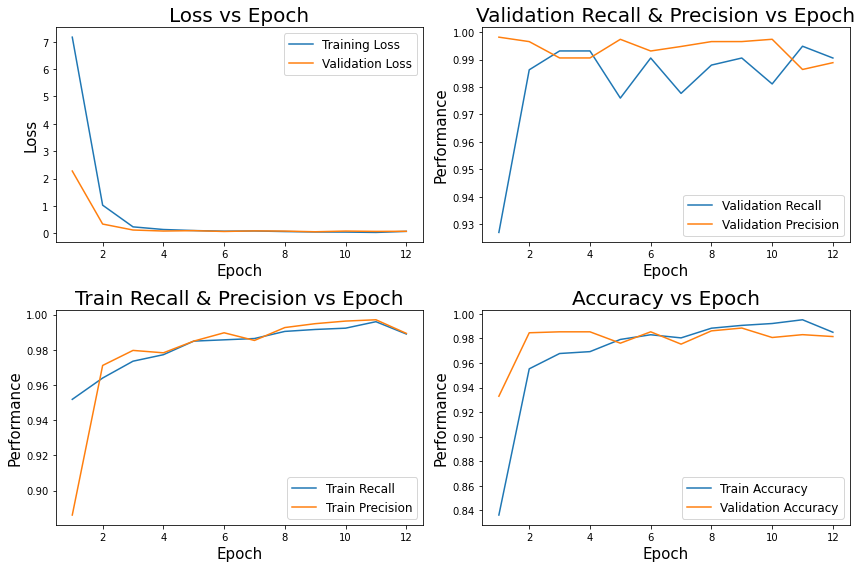

41/41 [==============================] - 15s 355ms/step - loss: 0.0548 - precision: 0.9965 - recall: 0.9905 - accuracy: 0.9884


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.034698,99.742645,99.779332,99.669546
1,Test,0.811040,78.427422,99.743587,82.692307
2,Validation,0.054783,99.654281,99.054980,98.844373


In [23]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version 8'] = train_model(cnn_8, train_gen, val_gen, 15)

# View History 
view_history(cnn, 'Version 8')

# Evaluate model
model_evaluate(cnn_8, train_gen, test_gen, val_gen)

I would say adding more neurons actually did not give any performance gain at all. This is where we should do data augmentation using Version 5

In [25]:
cnn_5.save("models/cnn5.keras")

In [26]:
cnn_5.save("models/cnn5control.keras")

# Data Augmentation

I made a function that augments our data and normalizes the data for training. Lets retrive our new data generators. 

In [34]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 3934 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.


Now that we have our data generators we can proceed to continue training our cnn10 & cnn 11 models with data augmentation

In [28]:
from tensorflow.keras.models import load_model

model_1 = load_model("models/cnn5.keras")

Epoch 1/15
123/123 [==============================] - 126s 1s/step - loss: 0.6548 - precision: 0.6930 - recall: 0.9430 - accuracy: 0.6718 - val_loss: 0.4647 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 2/15
123/123 [==============================] - 121s 986ms/step - loss: 0.6209 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4554 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 3/15
123/123 [==============================] - 126s 1s/step - loss: 0.6200 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4468 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 4/15
123/123 [==============================] - 123s 999ms/step - loss: 0.6188 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4417 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 5/15
123/123 [==============================] - 121s 982ms/step - loss: 0.6186 - precisi

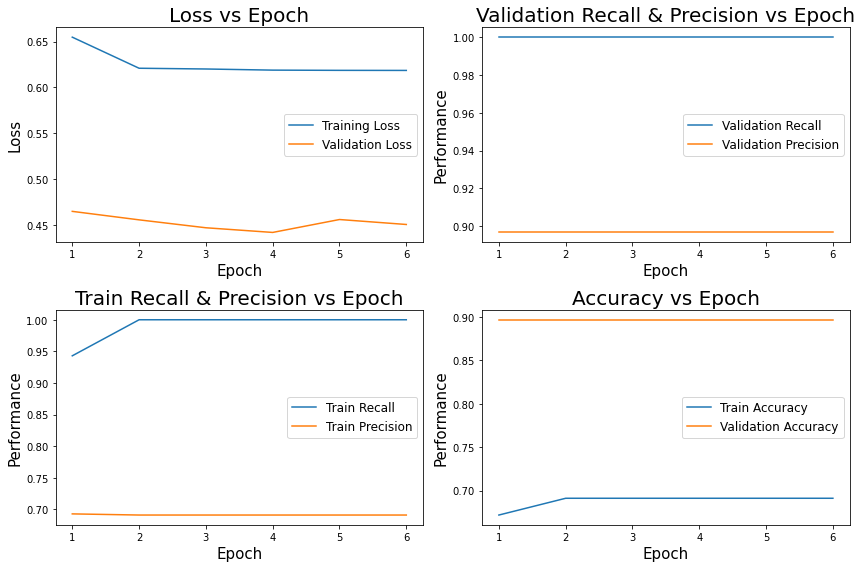

41/41 [==============================] - 14s 337ms/step - loss: 0.4468 - precision: 0.8968 - recall: 1.0000 - accuracy: 0.8968


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.618868,69.115406,100.0,69.115406
1,Test,0.674243,62.500000,100.0,62.500000
2,Validation,0.446760,89.676428,100.0,89.676428


In [29]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model1 = {}

# Train the model
cnn_aug_model1['Version1'] = train_model(model_1, train_gen_aug, val_gen_aug, 15)

# Visualize history 
view_history(cnn_aug_model1, 'Version1')

# Evaluate model
model_evaluate(model_1, train_gen_aug, test_gen_aug, val_gen_aug)

In [30]:
# Evaluate model
model_evaluate(model_1, train_gen, test_gen, val_gen)

41/41 [==============================] - 14s 329ms/step - loss: 0.4468 - precision: 0.8968 - recall: 1.0000 - accuracy: 0.8968


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.618868,69.115406,100.0,69.115406
1,Test,0.674243,62.500000,100.0,62.500000
2,Validation,0.446760,89.676428,100.0,89.676428


In [33]:
# Save our model from augmented training
model_1.save("models/cnn5_aug.keras")

Our losses in our test are much better. Every loss decreases suggetsing that the model is learning better. Unfortunartly our metrics did not improve by much however this model version is much more reliable then the pervious non augmented version

# Transfer Learning

Another method to use here would be to use an already pre trained network and see the results with our network

In [35]:
# Initialize Base
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Load in the pretrained CNN
cnn_base_vgg = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
    )

# Make configuration
model_pre = Sequential()
model_pre.add(cnn_base_vgg)
model_pre.add(Flatten())

# Define the same dense layers with our best cnn version that I made 
# Define our Dense Layers
model_pre.add(Dense(64, activation='relu'))
model_pre.add(Dropout(.2, seed=42))
model_pre.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
model_pre.add(Dense(64, activation='relu'))
model_pre.add(Dropout(.2, seed=42))
model_pre.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
model_pre.add(Dense(1, activation='sigmoid'))

# Define the pretrained model as an exclusion from changing its weights
cnn_base_vgg.trainable = False

model_pre.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_pre.summary())

80142336/80134624 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_______________________________________________________

Epoch 1/15
123/123 [==============================] - 422s 3s/step - loss: 6.7044 - precision: 0.8949 - recall: 0.9209 - accuracy: 0.8208 - val_loss: 2.5334 - val_precision: 0.9942 - val_recall: 0.8840 - val_accuracy: 0.8914
Epoch 2/15
123/123 [==============================] - 415s 3s/step - loss: 1.3153 - precision: 0.9202 - recall: 0.9033 - accuracy: 0.8790 - val_loss: 0.4619 - val_precision: 0.9605 - val_recall: 0.9811 - val_accuracy: 0.9468
Epoch 3/15
123/123 [==============================] - 416s 3s/step - loss: 0.4165 - precision: 0.9413 - recall: 0.9139 - accuracy: 0.9011 - val_loss: 0.2893 - val_precision: 0.9981 - val_recall: 0.8918 - val_accuracy: 0.9014
Epoch 4/15
123/123 [==============================] - 416s 3s/step - loss: 0.2781 - precision: 0.9429 - recall: 0.9235 - accuracy: 0.9085 - val_loss: 0.1307 - val_precision: 0.9895 - val_recall: 0.9708 - val_accuracy: 0.9646
Epoch 5/15
123/123 [==============================] - 418s 3s/step - loss: 0.2589 - precision: 0.942

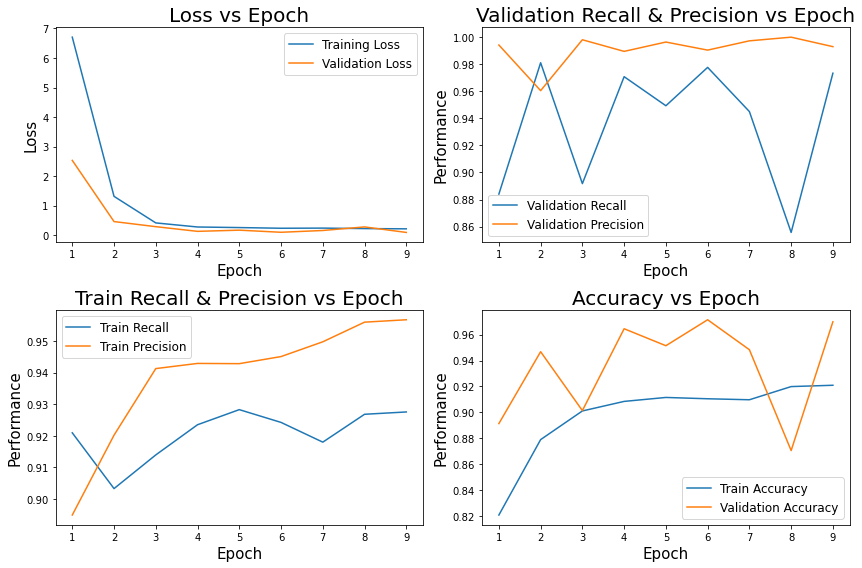

41/41 [==============================] - 101s 2s/step - loss: 0.0994 - precision: 0.9904 - recall: 0.9777 - accuracy: 0.9715


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.216484,91.911513,97.793305,92.526692
1,Test,0.347788,84.279478,98.974359,87.820512
2,Validation,0.099401,99.042648,97.766322,97.149462


In [36]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model2 = {}

# Train the model
cnn_aug_model2['Version1'] = train_model(model_pre, train_gen_aug, val_gen_aug, 15)

# Visualize history 
view_history(cnn_aug_model2, 'Version1')

# Evaluate model
model_evaluate(model_pre, train_gen_aug, test_gen_aug, val_gen_aug)

In [37]:
model_pre.save("models/cnnpre.keras")

Using the pretrained architecture we see how our loss are similar acorss the board. We perform better using the VGG19 according to our metrics. Our model version does not perform as great as the pretrained conv network. The final evaluation should be using the VGG19 network. 